In [1]:
import keras
import os
import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path 
from keras.optimizers import Adam
from keras import backend
from keras import optimizers
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
np.random.seed(1001)

Using TensorFlow backend.


In [2]:
class_names = os.listdir('/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/Train/')
target_dirs = {target: '/panfs/roc/groups/14/kumarbio/rai00016/Capstone/Data/NWPURESISC_19/' + target for target in ['Train', 'Validation', 'Test']}

In [3]:
batch_size = 64
train_data_generator =  ImageDataGenerator(rescale=1/255.0,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)
train_image_generator = train_data_generator.flow_from_directory(target_dirs['Train'],
                                                       target_size=(224, 224),
                                                       batch_size=batch_size,
                                                       shuffle=True)
test_data_generator =  ImageDataGenerator(rescale=1/255.0)
test_image_generator = test_data_generator.flow_from_directory(target_dirs['Test'],
                                                       target_size=(224, 224),
                                                       batch_size=batch_size,
                                                       shuffle=True)
validation_data_generator =  ImageDataGenerator(rescale=1/255.0)
validation_image_generator = validation_data_generator.flow_from_directory(target_dirs['Validation'],
                                                       target_size=(224, 224),
                                                       batch_size=batch_size,
                                                       shuffle=True) 
def getDataUsingDataGenerators(dataset):
    print(dataset)
    if dataset == 'Train':
        image_generator = train_image_generator
    elif dataset == 'Validation':
        image_generator = validation_image_generator
    else:
        image_generator = test_image_generator
    image_count = 0
    X_batches, Y_batches = [], []
    for X, Y in image_generator:
        X_batches.append(X)
        Y_batches.append(Y)
        image_count += X.shape[0]
        if image_count >= image_generator.n:
            break
    X = np.concatenate(X_batches)
    Y = np.concatenate(Y_batches)
    return X, Y 

Found 10640 images belonging to 19 classes.
Found 1330 images belonging to 19 classes.
Found 1330 images belonging to 19 classes.


In [4]:
num_classes = len(class_names)
X, Y = dict(), dict()
for dataset in [ 'Validation', 'Test','Train']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = getDataUsingDataGenerators(dataset)

Validation
Test
Train


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [6]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=num_classes,activation="softmax"))
    return model

In [7]:
model = build_model(input_shape=X['Train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)    

In [8]:
model_fit_history = model.fit_generator(train_image_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=100,
        validation_data=validation_image_generator,
        validation_steps=800 // batch_size)

Epoch 1/100
31/31 [==============================] - 270s 9s/step - loss: 4.0808 - accuracy: 0.1704 - val_loss: 3.3133 - val_accuracy: 0.0456
Epoch 2/100
31/31 [==============================] - 260s 8s/step - loss: 2.3567 - accuracy: 0.3140 - val_loss: 4.3996 - val_accuracy: 0.0623
Epoch 3/100
31/31 [==============================] - 261s 8s/step - loss: 2.0072 - accuracy: 0.3700 - val_loss: 4.2906 - val_accuracy: 0.0495
Epoch 4/100
31/31 [==============================] - 252s 8s/step - loss: 1.9386 - accuracy: 0.4081 - val_loss: 4.0685 - val_accuracy: 0.0623
Epoch 5/100
31/31 [==============================] - 260s 8s/step - loss: 1.7110 - accuracy: 0.4718 - val_loss: 4.3881 - val_accuracy: 0.0586
Epoch 6/100
31/31 [==============================] - 259s 8s/step - loss: 1.5802 - accuracy: 0.5035 - val_loss: 4.3653 - val_accuracy: 0.0517
Epoch 7/100
31/31 [==============================] - 261s 8s/step - loss: 1.5119 - accuracy: 0.5338 - val_loss: 4.6074 - val_accuracy: 0.0491
Epoch 

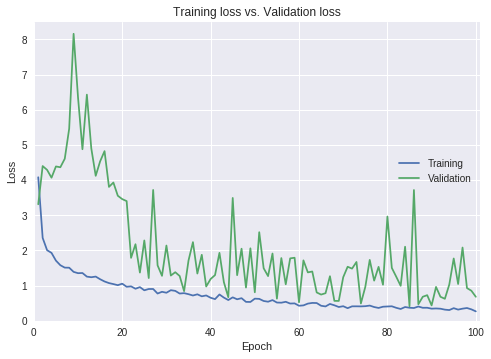

In [9]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

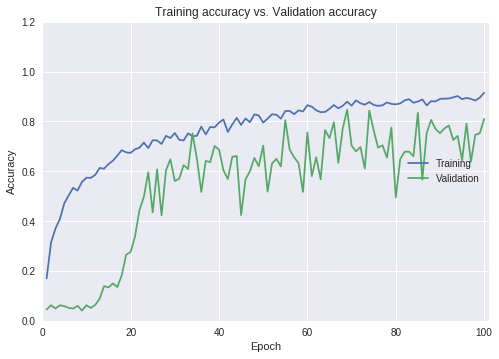

In [10]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['accuracy'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['accuracy'])
plt.plot(x, model_fit_history.history['val_accuracy'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

In [11]:
y_pred = model.predict_classes(X['Test'], verbose=0)

In [12]:
y_test = np.nonzero(Y['Test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

0.8157894736842105
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        70
           1       0.95      0.84      0.89        70
           2       0.57      0.99      0.72        70
           3       0.98      0.83      0.90        70
           4       0.80      0.80      0.80        70
           5       0.90      1.00      0.95        70
           6       0.67      0.73      0.70        70
           7       1.00      0.71      0.83        70
           8       0.96      0.91      0.93        70
           9       1.00      0.43      0.60        70
          10       0.73      0.80      0.76        70
          11       0.89      0.81      0.85        70
          12       0.90      0.61      0.73        70
          13       0.61      0.99      0.75        70
          14       0.97      0.84      0.90        70
          15       0.87      0.83      0.85        70
          16       0.79      0.94      0.86        70
        